In [ ]:
import numpy as np
import pandas as pd
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper",font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#merubah format kolom date lebih spesifik
dateparse = lambda x: pd.datetime.strptime(x,'%b %d, %Y')
#Membaca dataset
df=pd.read_csv('/content/drive/MyDrive/Data Science (ML,DL,Analyst)/BrentOilPrices1.csv',
               parse_dates=['Date'], date_parser=dateparse)
#mengurutkan dataset berdasarkan kolom Date
df=df.sort_values('Date')
df=df.groupby('Date')['Price'].sum().reset_index()
df.set_index('Date', inplace=True)
#Hanya menganalisa data tahun 2000
df=df.loc[datetime.date(year=2000,month=1,day=1):]
df

,Price
Date,
2000-01-04,23.95
2000-01-05,23.72
2000-01-06,23.55
2000-01-07,23.35
2000-01-10,22.77
...,...
2019-09-24,64.13
2019-09-25,62.41
2019-09-26,62.08


In [ ]:
#Membaca info dataframe
def infodf(df_initial):
    info_tab=pd.DataFrame(df_initial.dtypes).T.rename(
    index={0:'column type'})
    info_tab=info_tab.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    info_tab=info_tab.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                            rename(index={0: 'null values (%)'}))
    return info_tab

In [ ]:
infodf(df)

,Price
column type,float64
null values (nb),0
null values (%),0.0


In [ ]:

df.index

DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-17',
               ...
               '2019-09-17', '2019-09-18', '2019-09-19', '2019-09-20',
               '2019-09-23', '2019-09-24', '2019-09-25', '2019-09-26',
               '2019-09-27', '2019-09-30'],
              dtype='datetime64[ns]', name='Date', length=5016, freq=None)

In [ ]:
y=df['Price'].resample('MS').mean()
y.head()

Date
2000-01-01    25.511000
2000-02-01    27.775714
2000-03-01    27.486087
2000-04-01    22.764444
2000-05-01    27.737619
Freq: MS, Name: Price, dtype: float64

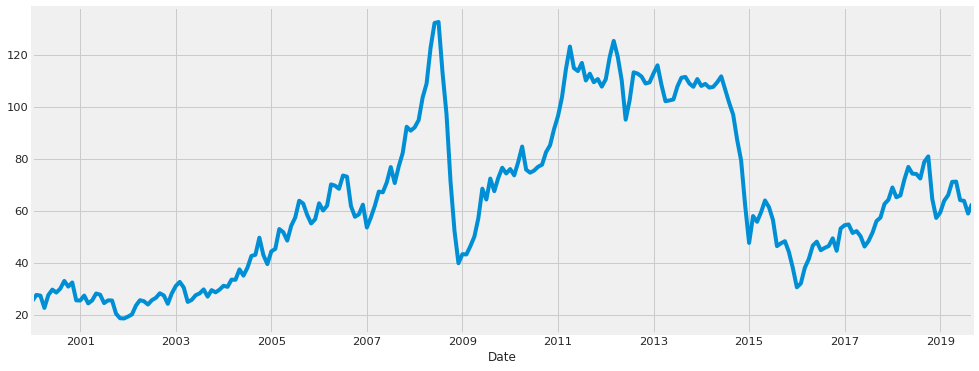

In [ ]:
y.plot(figsize=(15,6))
plt.show()

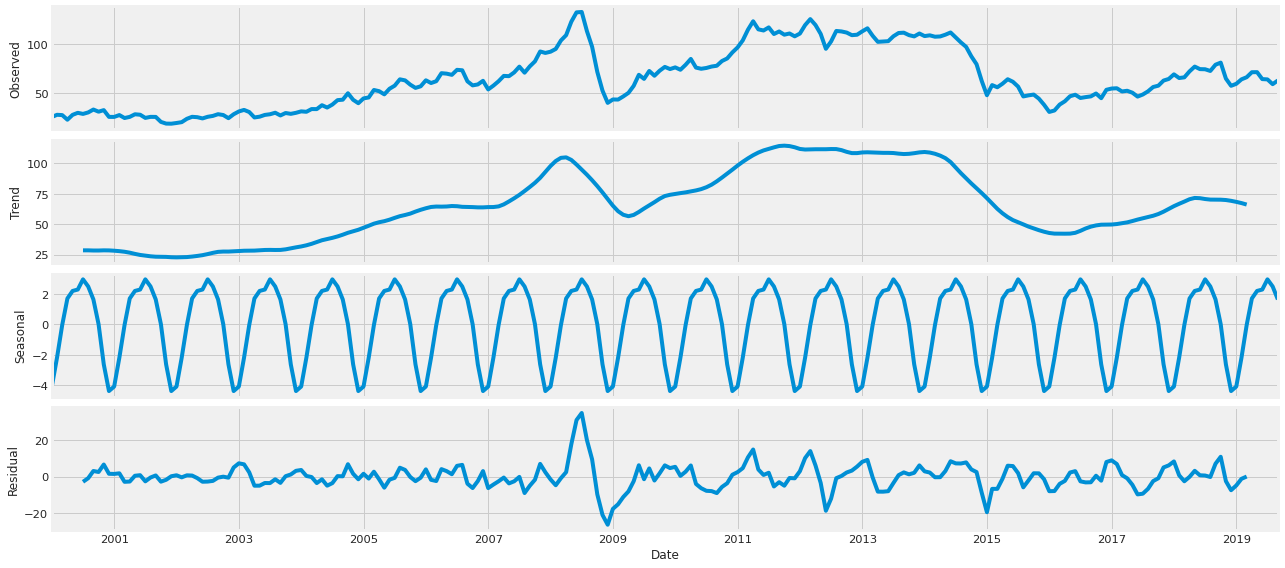

In [ ]:
rcParams['figure.figsize']=18,8
decomposition=sm.tsa.seasonal_decompose(y,model='additive')
fig=decomposition.plot()
plt.show()

In [ ]:
#Normalisasi dataset
sc=MinMaxScaler(feature_range=(0,1))
df=sc.fit_transform(df)

In [ ]:
#memisahkan data train dan test
train_size=int(len(df)*0.70) #70%
test_size=len(df)-train_size
train,test=df[0:train_size,:],df[train_size:len(df),:]

In [ ]:
def create_dataset(_data_set, _look_back=1):
    data_x,data_y=[],[]
    for i in range(len(_data_set)-_look_back-1):
        a=_data_set[i:(i+_look_back),0]
        data_x.append(a)
        data_y.append(_data_set[i+_look_back,0])
    return np.array(data_x), np.array(data_y)


In [ ]:
#reshape dari X=t dan Y=t+1
look_back=90
X_train, Y_train, X_test, Y_test=[],[],[],[]
X_train, Y_train = create_dataset(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test,Y_test=create_dataset(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [ ]:

# Membuat model LSTM
regressor=Sequential()

regressor.add(LSTM(units=60, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=60, return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam',loss='mean_squared_error')
reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test),
                       callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
228/228 [==============================] - 50s 195ms/step - loss: 0.0048 - val_loss: 0.0527 - lr: 0.0010
Epoch 2/20
228/228 [==============================] - 30s 131ms/step - loss: 0.0108 - val_loss: 0.0857 - lr: 0.0010
Epoch 3/20
228/228 [==============================] - 25s 110ms/step - loss: 0.0157 - val_loss: 0.1021 - lr: 0.0010
Epoch 4/20
228/228 [==============================] - 25s 111ms/step - loss: 0.0160 - val_loss: 0.0918 - lr: 0.0010
Epoch 5/20
228/228 [==============================] - 26s 113ms/step - loss: 0.0070 - val_loss: 0.0135 - lr: 0.0010
Epoch 6/20
228/228 [==============================] - 25s 111ms/step - loss: 0.0025 - val_loss: 0.0029 - lr: 0.0010
Epoch 7/20
228/228 [==============================] - 26s 113ms/step - loss: 0.0018 - val_loss: 0.0036 - lr: 0.0010
Epoch 8/20
228/228 [==============================] - 26s 116ms/step - loss: 0.0016 - val_loss: 0.0032 - lr: 0.0010
Epoch 9/20
228/228 [==============================] - 25s 110ms/step - l

In [ ]:
train_predict=regressor.predict(X_train)

In [ ]:
test_predict=regressor.predict(X_test)

In [ ]:
#invert predictions
train_predict=sc.inverse_transform(train_predict)
Y_train=sc.inverse_transform([Y_train])
test_predict=sc.inverse_transform(test_predict)
Y_test=sc.inverse_transform([Y_test])

Train Mean Absolute Error: 1.80435789271126
Train Root Mean Squared Error: 2.4260830902037154
Test Mean Absolute Error: 1.5784686246923203
Test Root Mean Squared Error: 1.993307261034464


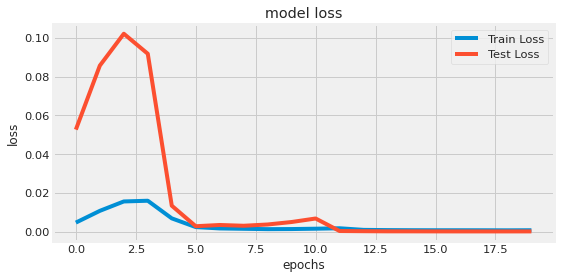

In [ ]:
print('Train Mean Absolute Error:',mean_absolute_error(Y_train[0],train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0],train_predict[:,0])))
print('Test Mean Absolute Error:',mean_absolute_error(Y_test[0],test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0],test_predict[:,0])))

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

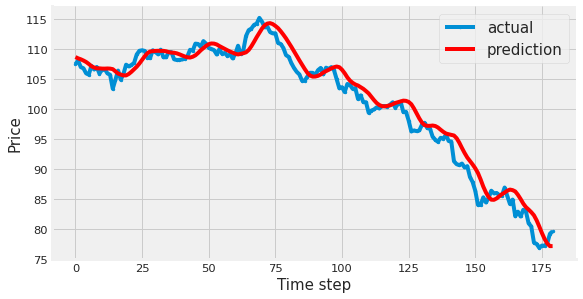

In [ ]:
#compare Actual vs Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa,Y_test[0][:180],marker='.',label="actual")
plt.plot(aa,test_predict[:,0][:180],'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price',size=15)
plt.xlabel('Time step',size=15)
plt.legend(fontsize=15)
plt.show()